<a href="https://colab.research.google.com/github/manlio99/DeTodoUnPoco/blob/main/Unet_Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Image segmentation with CamVid

https://medium.com/analytics-vidhya/image-segmentation-using-fastai-ddded25f811e

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch==1.4 torchvision==0.5.0
!pip install fastai==1.0.61 

     |████████████████████████████████| 753.4 MB 7.2 kB/s 
     |████████████████████████████████| 4.0 MB 31.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.4.0 which is incompatible.


In [ ]:
!pip install fastdebug

from fastdebug import *

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path_lbl = "/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/"
path_img = "/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/"


## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/0.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/1.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/2.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/0.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/1.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/2.png')]

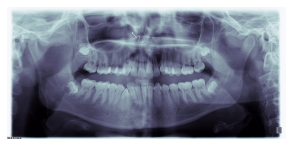

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [8]:
img.data.max()

tensor(1.)

In [9]:
# get_y_fn = lambda x: x
get_y_fn = lambda x: path_lbl+f'{x.stem}{x.suffix}'

In [10]:
img_f

PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/0.png')

In [11]:
get_y_fn(img_f)

'/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/0.png'

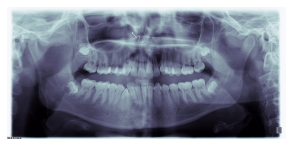

In [12]:
img = open_image(img_f)
img.show(figsize=(5,5))

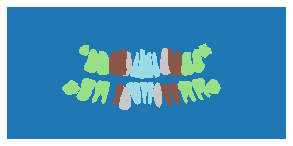

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [14]:
mask.data.max()

tensor(4)

In [15]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([302, 640]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [16]:
codes = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/labels.txt', dtype=str)
# codes = np.array(["molares", "premolares", "caninos", "incisivos"], dtype=str)
codes

array(['encia', 'molares', 'premolares', 'caninos', 'incisivos'], dtype='<U10')

## Datasets

In [17]:
size = (3, 302, 640)# src_size  #(360, 480) //2

free = gpu_mem_get_free_no_cache()
# if free > 8200: 
#   bs=8
# else:
#   bs=4
bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")
size

using bs=4, have 11438 MB of GPU RAM free


(3, 302, 640)

In [24]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(seed=1995)
       .label_from_func( get_y_fn, classes=codes)
       )
# .split_by _fname_file('../valid.txt')  .split_none()

In [25]:
src.transform(size=224, tfm_y=True)
src.get_processors

<bound method LabelLists.get_processors of LabelLists;

Train: LabelList (44 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images;

Valid: LabelList (10 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images;

Test: None>

In [26]:
data = (src.transform(size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

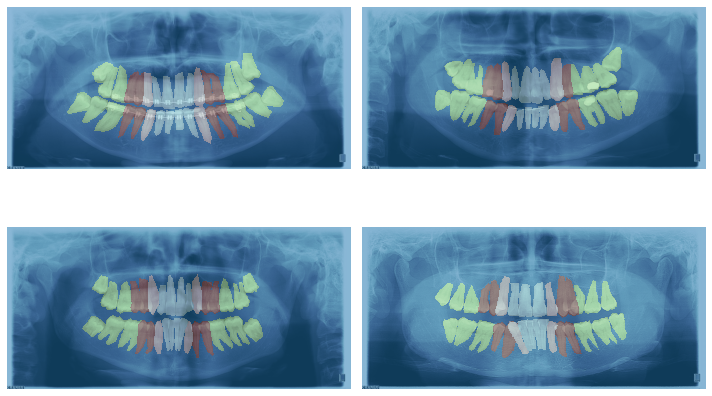

In [27]:
data.show_batch(2, figsize=(10, 7))

## Model

In [37]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id.values()

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [33]:
metrics = acc_camvid

In [34]:
wd = 1e-2

In [38]:
# create unet
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


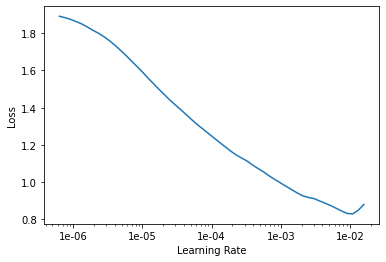

In [40]:
learn.recorder.plot()

In [41]:
lr = 3e-3

In [42]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.727348,0.456187,0.832097,00:28
1,0.536273,0.336760,0.865761,00:20
2,0.444299,0.420717,0.855466,00:21
3,0.410926,0.295778,0.884569,00:20
4,0.382117,0.320310,0.876286,00:21
5,0.356728,0.315173,0.876909,00:20
6,0.331614,1.092358,0.832991,00:20
7,0.451422,0.997214,0.824507,00:21
8,0.527047,0.577308,0.830130,00:20
9,0.581407,0.641274,0.824496,00:20


In [43]:
learn.save('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/fastai_dientes_1')


# learn.load('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/fastai_dientes_1');



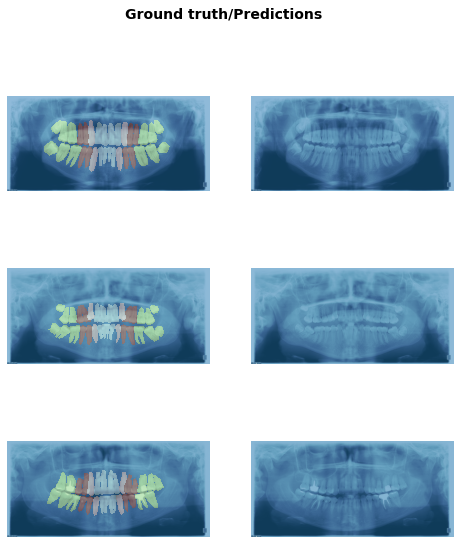

In [44]:
learn.show_results(rows=3, figsize=(8, 9))

In [45]:
learn.unfreeze()

In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


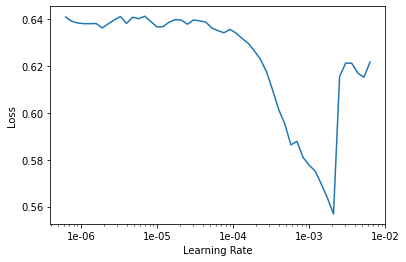

In [47]:
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(12, slice(lr/300, lr/3), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.631389,0.613131,0.824498,00:21
1,0.601950,0.498551,0.825846,00:21
2,0.521145,0.374775,0.863610,00:21
3,0.460525,0.321824,0.873228,00:21
4,0.413825,0.274558,0.894439,00:21
5,0.372799,0.221506,0.919037,00:21
6,0.335073,0.206754,0.924172,00:21
7,0.298456,0.330803,0.901194,00:21
8,0.295112,0.265762,0.913613,00:21
9,0.270601,0.157336,0.939846,00:21


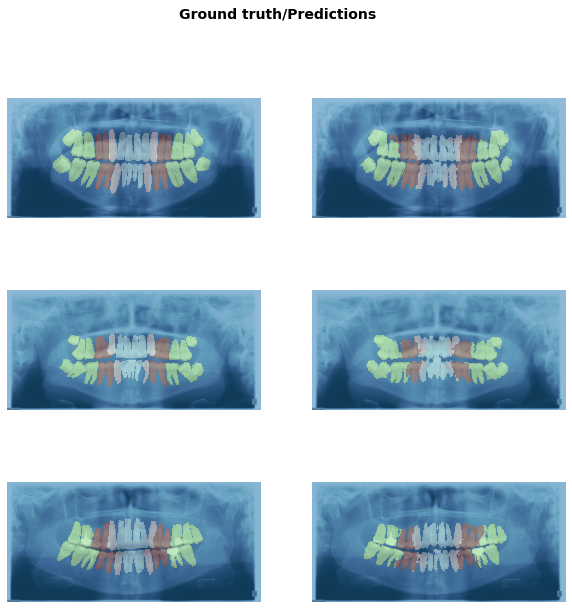

In [49]:
learn.show_results(rows=3, figsize=(10, 10))

In [50]:
learn.save('camvid-stage-2')

## Train on bigger images

In [51]:
learn.destroy()

size = src_size // 1.5

free = gpu_mem_get_free_no_cache()
if free > 8200: 
  bs=3
else: 
  bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 10120MB of GPU RAM free


In [56]:
data = (src.transform(size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [57]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [58]:
learn.load('camvid-stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


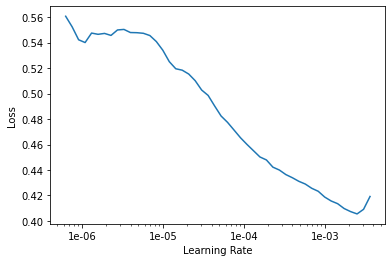

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
lr = 3e-3

In [61]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.345747,0.309670,0.883157,00:15
1,0.315024,0.283615,0.886611,00:11
2,0.288858,0.266878,0.901130,00:11
3,0.262166,0.264886,0.894342,00:11
4,0.257068,0.235966,0.910013,00:11
5,0.270314,0.430377,0.867999,00:11
6,0.309276,0.279742,0.896297,00:11
7,0.290021,0.220575,0.916972,00:11
8,0.272674,0.198210,0.923960,00:11
9,0.244159,0.186808,0.927617,00:11


In [62]:
learn.save('camvid-big-stage-1')

In [63]:
learn.unfreeze()

In [64]:
learn.fit_one_cycle(10, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.150474,0.174701,0.931447,00:12
1,0.145182,0.169482,0.934377,00:12
2,0.137948,0.167002,0.937566,00:11
3,0.131338,0.166852,0.938062,00:12
4,0.125817,0.165584,0.939208,00:11
5,0.121144,0.164255,0.940479,00:11
6,0.116230,0.157928,0.943302,00:11
7,0.112103,0.155622,0.942732,00:11
8,0.108667,0.157091,0.943142,00:11
9,0.105571,0.159187,0.942773,00:11


In [65]:
learn.save('stage-2-big')

## Interpretation

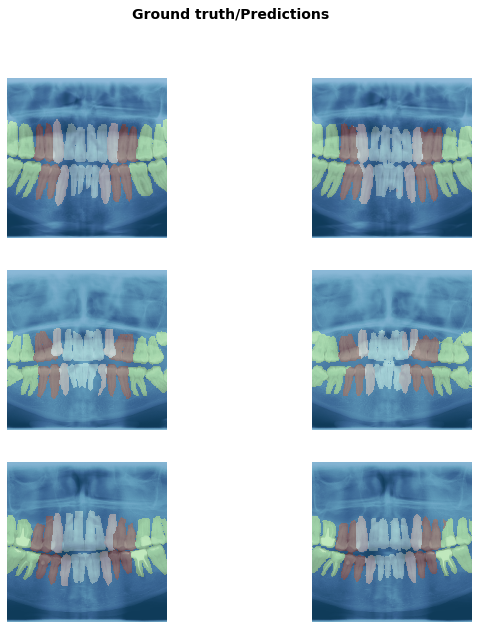

In [66]:
learn.show_results(rows=3, figsize=(10, 10))